# Download data
This notebook is used to download databases through APIs such as Earth Engine. Data: 17-07-2024

## Import packages

In [2]:
import ee
from owslib.wcs import WebCoverageService

In [3]:
# Initialize the Earth Engine library.
ee.Initialize()

In [4]:
#This rectangle needs to cover the countries bounding box
geometry = ee.Geometry.Rectangle([102.0, 10.0, 108.0, 15.0])

## Elevation model

In [14]:
# Load a Nasa DEM image and select three bands.
nasadem = ee.Image('NASA/NASADEM_HGT/001').select('elevation')

# Retrieve the projection information from a band of the original image.

# Export the image, specifying the CRS, transform, and region.
task = ee.batch.Export.image.toDrive(image=nasadem,
                                     description=f'nasadem-khm',
                                     region=geometry.getInfo()['coordinates'], 
                                     folder='usaid-cambodia', 
                                     maxPixels=1000000000)
task.start()


## Hansen

In [17]:
# Load a Hansen image and select three bands.
hnsn = ee.Image("UMD/hansen/global_forest_change_2023_v1_11").select(['treecover2000', 'loss', 'lossyear'])

# Export the image, specifying the CRS, transform, and region.
task = ee.batch.Export.image.toDrive(image=hnsn,
                                     description='hansen-khm',
                                     region=geometry.getInfo()['coordinates'], 
                                     folder='usaid-cambodia', 
                                     maxPixels=1000000000)
task.start()


## Soil Organic Carbon

In [44]:
from owslib.wcs import WebCoverageService

wcs = WebCoverageService('https://maps.isric.org/mapserv?map=/map/soc.map',
                         version='2.0.1')

In [45]:
print(list(wcs.contents))

['soc_0-5cm_Q0.5', 'soc_0-5cm_Q0.05', 'soc_0-5cm_Q0.95', 'soc_0-5cm_mean', 'soc_0-5cm_uncertainty', 'soc_5-15cm_Q0.05', 'soc_5-15cm_Q0.5', 'soc_5-15cm_Q0.95', 'soc_5-15cm_mean', 'soc_5-15cm_uncertainty', 'soc_15-30cm_Q0.5', 'soc_15-30cm_Q0.05', 'soc_15-30cm_Q0.95', 'soc_15-30cm_mean', 'soc_15-30cm_uncertainty', 'soc_30-60cm_Q0.05', 'soc_30-60cm_Q0.5', 'soc_30-60cm_Q0.95', 'soc_30-60cm_mean', 'soc_30-60cm_uncertainty', 'soc_60-100cm_Q0.05', 'soc_60-100cm_Q0.5', 'soc_60-100cm_Q0.95', 'soc_60-100cm_mean', 'soc_60-100cm_uncertainty', 'soc_100-200cm_Q0.05', 'soc_100-200cm_Q0.5', 'soc_100-200cm_Q0.95', 'soc_100-200cm_mean', 'soc_100-200cm_uncertainty']


In [46]:
cov_id = 'soc_0-5cm_mean'
ph_0_5 = wcs.contents[cov_id]
ph_0_5.supportedFormats

['image/tiff',
 'image/png',
 'image/jpeg',
 'image/png; mode=8bit',
 'image/vnd.jpeg-png',
 'image/vnd.jpeg-png8']

In [47]:
#EPSG:152160
subsets = [('X', 11056114.325078709, 11856013.401957477), ('Y', 890555.9263461885, 1892431.3434856508)]


In [48]:
crs = "http://www.opengis.net/def/crs/EPSG/0/152160"

In [49]:
response = wcs.getCoverage(
    identifier=[cov_id], 
    crs=crs,
    subsets=subsets, 
    resx=250, resy=250, 
    format=ph_0_5.supportedFormats[0])

In [50]:
with open('./khm_soc_0-5_mean.tif', 'wb') as file:
    file.write(response.read())

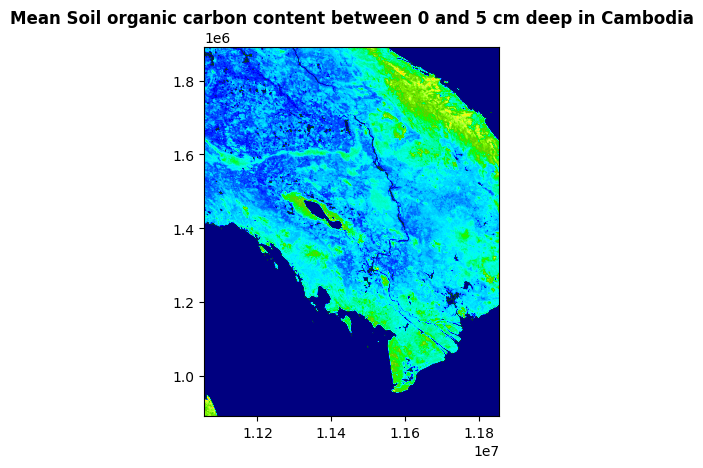

<Axes: title={'center': 'Mean Soil organic carbon content between 0 and 5 cm deep in Cambodia'}>

In [51]:
import rasterio
from rasterio import plot

ph = rasterio.open("./khm_soc_0-5_mean.tif", driver="GTiff")
%matplotlib inline
plot.show(ph, title='Mean Soil organic carbon content between 0 and 5 cm deep in Cambodia', cmap='gist_ncar')

## NPP (Net Primary Productivity)

In [7]:
# Load the ImageCollection
modis_npp_collection = ee.ImageCollection("MODIS/061/MOD17A3HGF")

In [8]:
# Get the size of the collection
collection_size = modis_collection.size().getInfo()
print(f"Number of images in the collection: {collection_size}")

Number of images in the collection: 23


In [9]:
# Get the first image in the collection
first_image = modis_collection.first()
# Get information about the first image
first_image_info = first_image.getInfo()
print("First image info:", first_image_info)

First image info: {'type': 'Image', 'bands': [{'id': 'Gpp', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [86400, 36000], 'crs': 'SR-ORG:6974', 'crs_transform': [463.3127165279165, 0, -20015109.354, 0, -463.3127165279167, 10007554.677003]}, {'id': 'Npp', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': -32768, 'max': 32767}, 'dimensions': [86400, 36000], 'crs': 'SR-ORG:6974', 'crs_transform': [463.3127165279165, 0, -20015109.354, 0, -463.3127165279167, 10007554.677003]}, {'id': 'Npp_QC', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 255}, 'dimensions': [86400, 36000], 'crs': 'SR-ORG:6974', 'crs_transform': [463.3127165279165, 0, -20015109.354, 0, -463.3127165279167, 10007554.677003]}], 'version': 1652312577644407, 'id': 'MODIS/061/MOD17A3HGF/2001_01_01', 'properties': {'system:time_start': 978307200000, 'google:max_source_file_timestamp': 1651822643000, 'system:footprint': {'type': 'LinearRing', 'coo

In [11]:
# Get the list of all image IDs in the collection (limited to avoid excessive output)
image_ids = modis_collection.aggregate_array('system:id').getInfo()
print("Image IDs in the collection (limited to first 10):", image_ids)


Image IDs in the collection (limited to first 10): ['MODIS/061/MOD17A3HGF/2001_01_01', 'MODIS/061/MOD17A3HGF/2002_01_01', 'MODIS/061/MOD17A3HGF/2003_01_01', 'MODIS/061/MOD17A3HGF/2004_01_01', 'MODIS/061/MOD17A3HGF/2005_01_01', 'MODIS/061/MOD17A3HGF/2006_01_01', 'MODIS/061/MOD17A3HGF/2007_01_01', 'MODIS/061/MOD17A3HGF/2008_01_01', 'MODIS/061/MOD17A3HGF/2009_01_01', 'MODIS/061/MOD17A3HGF/2010_01_01', 'MODIS/061/MOD17A3HGF/2011_01_01', 'MODIS/061/MOD17A3HGF/2012_01_01', 'MODIS/061/MOD17A3HGF/2013_01_01', 'MODIS/061/MOD17A3HGF/2014_01_01', 'MODIS/061/MOD17A3HGF/2015_01_01', 'MODIS/061/MOD17A3HGF/2016_01_01', 'MODIS/061/MOD17A3HGF/2017_01_01', 'MODIS/061/MOD17A3HGF/2018_01_01', 'MODIS/061/MOD17A3HGF/2019_01_01', 'MODIS/061/MOD17A3HGF/2020_01_01', 'MODIS/061/MOD17A3HGF/2021_01_01', 'MODIS/061/MOD17A3HGF/2022_01_01', 'MODIS/061/MOD17A3HGF/2023_01_01']


In [12]:
# Load the specific MODIS image from the ImageCollection
modis_image = ee.Image('MODIS/061/MOD17A3HGF/2010_01_01').select(['Npp']).int16()

# Export the image, specifying the CRS, transform, and region.
task = ee.batch.Export.image.toDrive(image=modis_image,
                                     description='npp_2010_khm',
                                     scale=250,
                                     region=geometry.getInfo()['coordinates'], 
                                     folder='usaid-cambodia')
task.start()


## NDVI

In [23]:
# Load the ImageCollection
modis_collection = ee.ImageCollection("MODIS/061/MOD13Q1")
# Get the size of the collection
collection_size = modis_collection.size().getInfo()
print(f"Number of images in the collection: {collection_size}")

Number of images in the collection: 562


In [ ]:
# Get the first image in the collection
first_image = modis_collection.first()
# Get information about the first image
first_image_info = first_image.getInfo()
print("First image info:", first_image_info)

In [66]:
# Get the list of all image IDs in the collection (limited to avoid excessive output)
image_ids = modis_collection.aggregate_array('system:id').getInfo()
print("Image IDs in the collection (limited to first 10):", image_ids[-350:-310])

Image IDs in the collection (limited to first 10): ['MODIS/061/MOD13Q1/2009_05_09', 'MODIS/061/MOD13Q1/2009_05_25', 'MODIS/061/MOD13Q1/2009_06_10', 'MODIS/061/MOD13Q1/2009_06_26', 'MODIS/061/MOD13Q1/2009_07_12', 'MODIS/061/MOD13Q1/2009_07_28', 'MODIS/061/MOD13Q1/2009_08_13', 'MODIS/061/MOD13Q1/2009_08_29', 'MODIS/061/MOD13Q1/2009_09_14', 'MODIS/061/MOD13Q1/2009_09_30', 'MODIS/061/MOD13Q1/2009_10_16', 'MODIS/061/MOD13Q1/2009_11_01', 'MODIS/061/MOD13Q1/2009_11_17', 'MODIS/061/MOD13Q1/2009_12_03', 'MODIS/061/MOD13Q1/2009_12_19', 'MODIS/061/MOD13Q1/2010_01_01', 'MODIS/061/MOD13Q1/2010_01_17', 'MODIS/061/MOD13Q1/2010_02_02', 'MODIS/061/MOD13Q1/2010_02_18', 'MODIS/061/MOD13Q1/2010_03_06', 'MODIS/061/MOD13Q1/2010_03_22', 'MODIS/061/MOD13Q1/2010_04_07', 'MODIS/061/MOD13Q1/2010_04_23', 'MODIS/061/MOD13Q1/2010_05_09', 'MODIS/061/MOD13Q1/2010_05_25', 'MODIS/061/MOD13Q1/2010_06_10', 'MODIS/061/MOD13Q1/2010_06_26', 'MODIS/061/MOD13Q1/2010_07_12', 'MODIS/061/MOD13Q1/2010_07_28', 'MODIS/061/MOD13Q1/2

In [35]:
MOD13Q1_2010 = [item for item in image_ids if "2010" in item]

In [47]:
for image in MOD13Q1_2010:

    # Load the specific MODIS image from the ImageCollection
    modis_image = ee.Image(image).select(['NDVI']).int16()
    
    # Export the image, specifying the CRS, transform, and region.
    task = ee.batch.Export.image.toDrive(image=modis_image,
                                         description='NDVI_' + image[-10:] + '_KHM', 
                                         crs='EPSG:4326',
                                         scale=250,
                                         region=geometry.getInfo()['coordinates'], 
                                         folder='usaid-cambodia')
    task.start()


##### First approach
This approach was the one initially used to calculated the gdp layer. 

This approach consists of creating a function to convert the gpd raster into a shapefile where geometries are the grids cells. With this function is only possible to use the 5arcmin (10km) resolution layer because the one with a higher resolution is too large, causing the kernel to crash.

In [11]:
def calculate_gdp_ppp(gdf, path, col_to_groupby, year=2015):

    """
    Returns the GeoDataFrame with the calculation of GDP by grid.
    ------
    
    Parameters:
    gdf: The dataframe of grids or other division of zones.
    path: Path to the raster with the GDP of the world or the region at a 30x30m resolution.
    col_to_groupby: The column in gdf by which the GDP calculations are grouped. In the case of the base cartography, it is ID_2, which is the municipality.
    """
    # Opens the netCDF file
    data = xr.open_dataset(path)

    #Select only GDP_PPP 
    gdp = data['GDP_PPP']
    
    #Select the year
    time_index = (gdp['time'] == year).argmax().values
    gdp_2015 = gdp.isel(time=time_index)
    
    #Create a gdf
    crs = data.projection
    df = gdp_2015.to_dataframe().reset_index()
    df.drop('time', inplace=True, axis=1)
    geometry = gpd.points_from_xy(df['longitude'], df['latitude'], crs=crs)     #Crear la geometría a partir de los puntos
    gdp = gpd.GeoDataFrame(df['GDP_PPP'], geometry=geometry) 
    gdp = gdp.to_crs(gdf.crs)
    
    #Calcular el gdp para cada region y devolverlo a la gdf original
    gdf_gdp = gpd.clip(gdp, gdf) #Clip to the shape of the country
    
    print(gdf_gdp['GDP_PPP'].sum())
    
    df = gdf_gdp.sjoin(gdf[[col_to_groupby, 'geometry']]) #Sacar las estadísticas regionales con un sjoin
    pib = df[[col_to_groupby, 'GDP_PPP']].groupby([col_to_groupby]).sum() #Diccionario con los valores del PIB para cada municipio
    gdf = gdf.merge(pib.reset_index(), how='left', on=[col_to_groupby]) #Se agregan de vuelta al dataframe principal

    return gdf

In [13]:
%%time
df = calculate_gdp_ppp(gdf=country_grids,
                       path=data_folder + 'gdp/doi_10_5061_dryad_dk1j0__v20200213/GDP_PPP_1990_2015_5arcmin_v2.nc', 
                       col_to_groupby='grid_id')

50956657000.0
CPU times: user 6.62 s, sys: 5.59 s, total: 12.2 s
Wall time: 14.7 s


In [14]:
%%time
# Adjust inflation
df['GDP_PPP'] = df['GDP_PPP'].apply(lambda x: mapas_raster.adjust_for_inflation(x, 
                                                                                2011, 
                                                                                2022, 
                                                                                paths['inflation_usa']))

CPU times: user 7.02 s, sys: 627 ms, total: 7.65 s
Wall time: 7.92 s
